In [1]:
import plotly.offline as pyo
pyo.init_notebook_mode()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn import preprocessing
import random
import tensorflow as tf
import warnings
warnings.filterwarnings("ignore")
!pip install visualkeras
!pip install pydicom
import pydicom as dicom
import os
import numpy
from matplotlib import pyplot, cm

In [2]:
df = pd.read_csv('switch_1_flowcount.csv')
df['time'] = pd.to_datetime(df['time'], format='%m/%d/%Y, %H:%M:%S', errors='coerce')
import pandas as pd

# Assuming df is your DataFrame
df['flowcount'] = pd.to_numeric(df['flowcount'], errors='coerce')
df = df.dropna(subset=['flowcount']).astype({'flowcount': 'int64'})

df.head()

time  flowcount
0 2023-12-18 00:26:08          5
1 2023-12-18 00:26:10          9
2 2023-12-18 00:26:12          9
3 2023-12-18 00:26:14         11
4 2023-12-18 00:26:16         11

# EDA

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# A. Fill numeric missing values by median and categorical by mode
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = df.select_dtypes(include=['object']).columns

categorical_columns



Index([], dtype='object')

## Values to be filled

In [4]:
df[numeric_columns].median()

flowcount    91.0
dtype: float64

In [5]:
# Fill numeric missing values with median
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].median())




In [6]:
df.dtypes

time         datetime64[ns]
flowcount             int64
dtype: object

# Statistics

In [7]:
df.describe()

flowcount
count    524.000000
mean    3779.133588
std     5305.904152
min        5.000000
25%       91.000000
50%       91.000000
75%     7001.500000
max    20401.000000

In [8]:
df

time  flowcount
0   2023-12-18 00:26:08          5
1   2023-12-18 00:26:10          9
2   2023-12-18 00:26:12          9
3   2023-12-18 00:26:14         11
4   2023-12-18 00:26:16         11
..                  ...        ...
520 2023-12-18 00:48:10      19117
521 2023-12-18 00:48:18      19352
522 2023-12-18 00:48:27      19739
523 2023-12-18 00:48:36      20049
524 2023-12-18 00:48:46      20401

[524 rows x 2 columns]

# Preprocessing

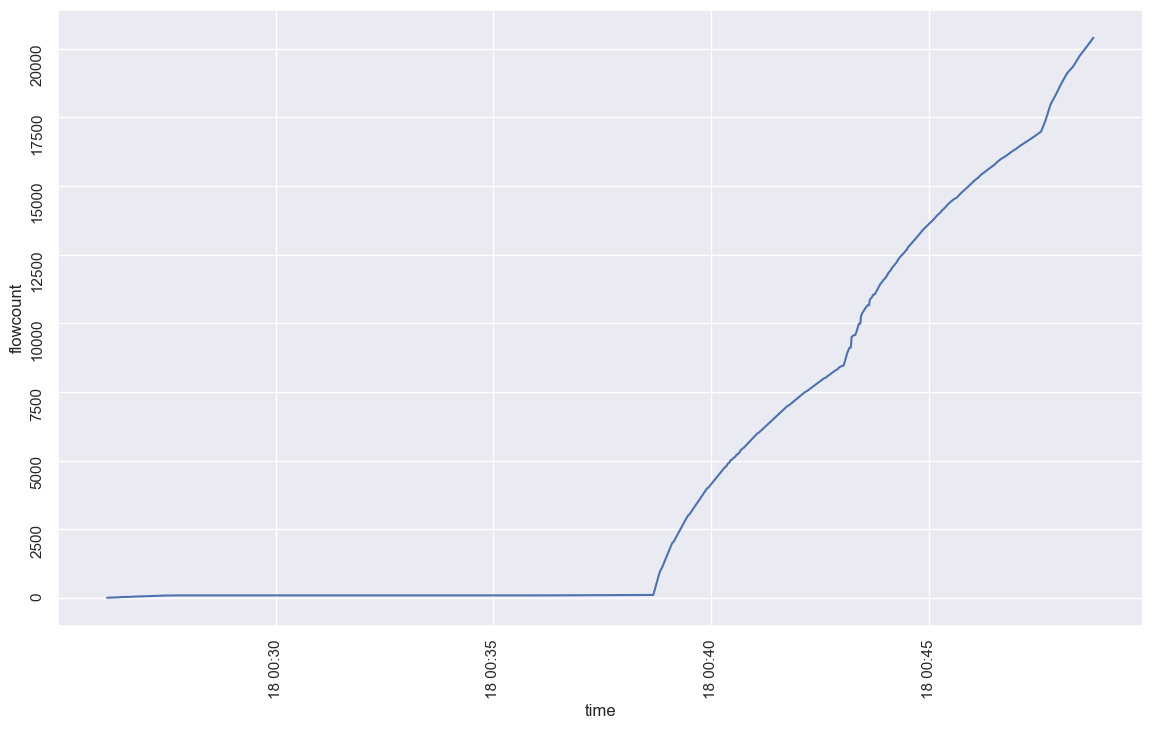

In [9]:
sns.set(rc={'figure.figsize': (14, 8)})
sns.lineplot(data=df, x="time", y="flowcount")
plt.xticks(rotation=90)
plt.yticks(rotation=90)
plt.show()

In [10]:
!pip install darts

In [11]:
df

time  flowcount
0   2023-12-18 00:26:08          5
1   2023-12-18 00:26:10          9
2   2023-12-18 00:26:12          9
3   2023-12-18 00:26:14         11
4   2023-12-18 00:26:16         11
..                  ...        ...
520 2023-12-18 00:48:10      19117
521 2023-12-18 00:48:18      19352
522 2023-12-18 00:48:27      19739
523 2023-12-18 00:48:36      20049
524 2023-12-18 00:48:46      20401

[524 rows x 2 columns]

In [12]:
duplicates = df[df.duplicated('time')]
print(duplicates)


Empty DataFrame
Columns: [time, flowcount]
Index: []


In [13]:
# from darts import TimeSeries
# get_data = TimeSeries.from_dataframe(df, 'time', 'flowcount',fill_missing_dates=True, freq='1H')


In [14]:
# from darts.datasets import AirPassengersDataset, MonthlyMilkDataset
# import matplotlib.pyplot as plt
# from matplotlib.pyplot import figure
# figure(figsize=(8, 6), dpi=300)
# get_data.plot(label='Growth in Flows')
# plt.legend();

## Normalisation


In [15]:
min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
dataset = min_max_scaler.fit_transform(df['flowcount'].values.reshape(-1, 1))
train_size = int(len(dataset) * 0.7)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

366 158


In [16]:
def create_dataset(dataset, look_back=5):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
x_train, y_train = create_dataset(dataset, look_back=5)
x_test, y_test = create_dataset(test, look_back=5)
print(x_train.shape)
print(y_train.shape)

(518, 5)
(518,)


In [17]:
x_train

array([[0.00000000e+00, 1.96116886e-04, 1.96116886e-04, 2.94175328e-04,
        2.94175328e-04],
       [1.96116886e-04, 1.96116886e-04, 2.94175328e-04, 2.94175328e-04,
        4.90292214e-04],
       [1.96116886e-04, 2.94175328e-04, 2.94175328e-04, 4.90292214e-04,
        4.90292214e-04],
       ...,
       [8.52274956e-01, 8.81055109e-01, 8.97872132e-01, 9.18856639e-01,
        9.37046480e-01],
       [8.81055109e-01, 8.97872132e-01, 9.18856639e-01, 9.37046480e-01,
        9.48568347e-01],
       [8.97872132e-01, 9.18856639e-01, 9.37046480e-01, 9.48568347e-01,
        9.67542655e-01]])

In [18]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def cross_val(model,X,y):
    pred = cross_val_score(model, X, y, cv=10)
    return pred.mean()

def print_evaluate(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('R2 Square', r2_square)
    print('__________________________________')
    
def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    r2_square = metrics.r2_score(true, predicted)
    return mae, mse, rmse, r2_square

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('std_scalar', StandardScaler())
])

X_train = pipeline.fit_transform(x_train)
!pip install hvplot

         Real  predicted
0    0.000490   0.000375
1    0.000490   0.000620
2    0.000490   0.000592
3    0.000588   0.000567
4    0.000883   0.000679
..        ...        ...
513  0.918857   0.916471
514  0.937046   0.938037
515  0.948568   0.954969
516  0.967543   0.963420
517  0.982742   0.983095

[518 rows x 2 columns]
Train set evaluation:
_____________________________________
MAE: 0.000529516062655558
MSE: 2.88557539602836e-06
RMSE: 0.0016986981474141779
R2 Square 0.9999567485759379
__________________________________
_____________________________________
Name LinearRegression
Test set evaluation:
_____________________________________
MAE: 0.000529516062655558
MSE: 2.88557539602836e-06
RMSE: 0.0016986981474141779
R2 Square 0.9999567485759379
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.000529516062655558
MSE: 2.88557539602836e-06
RMSE: 0.0016986981474141779
R2 Square 0.9999567485759379
__________________________________
     

<Figure size 2400x1800 with 0 Axes>

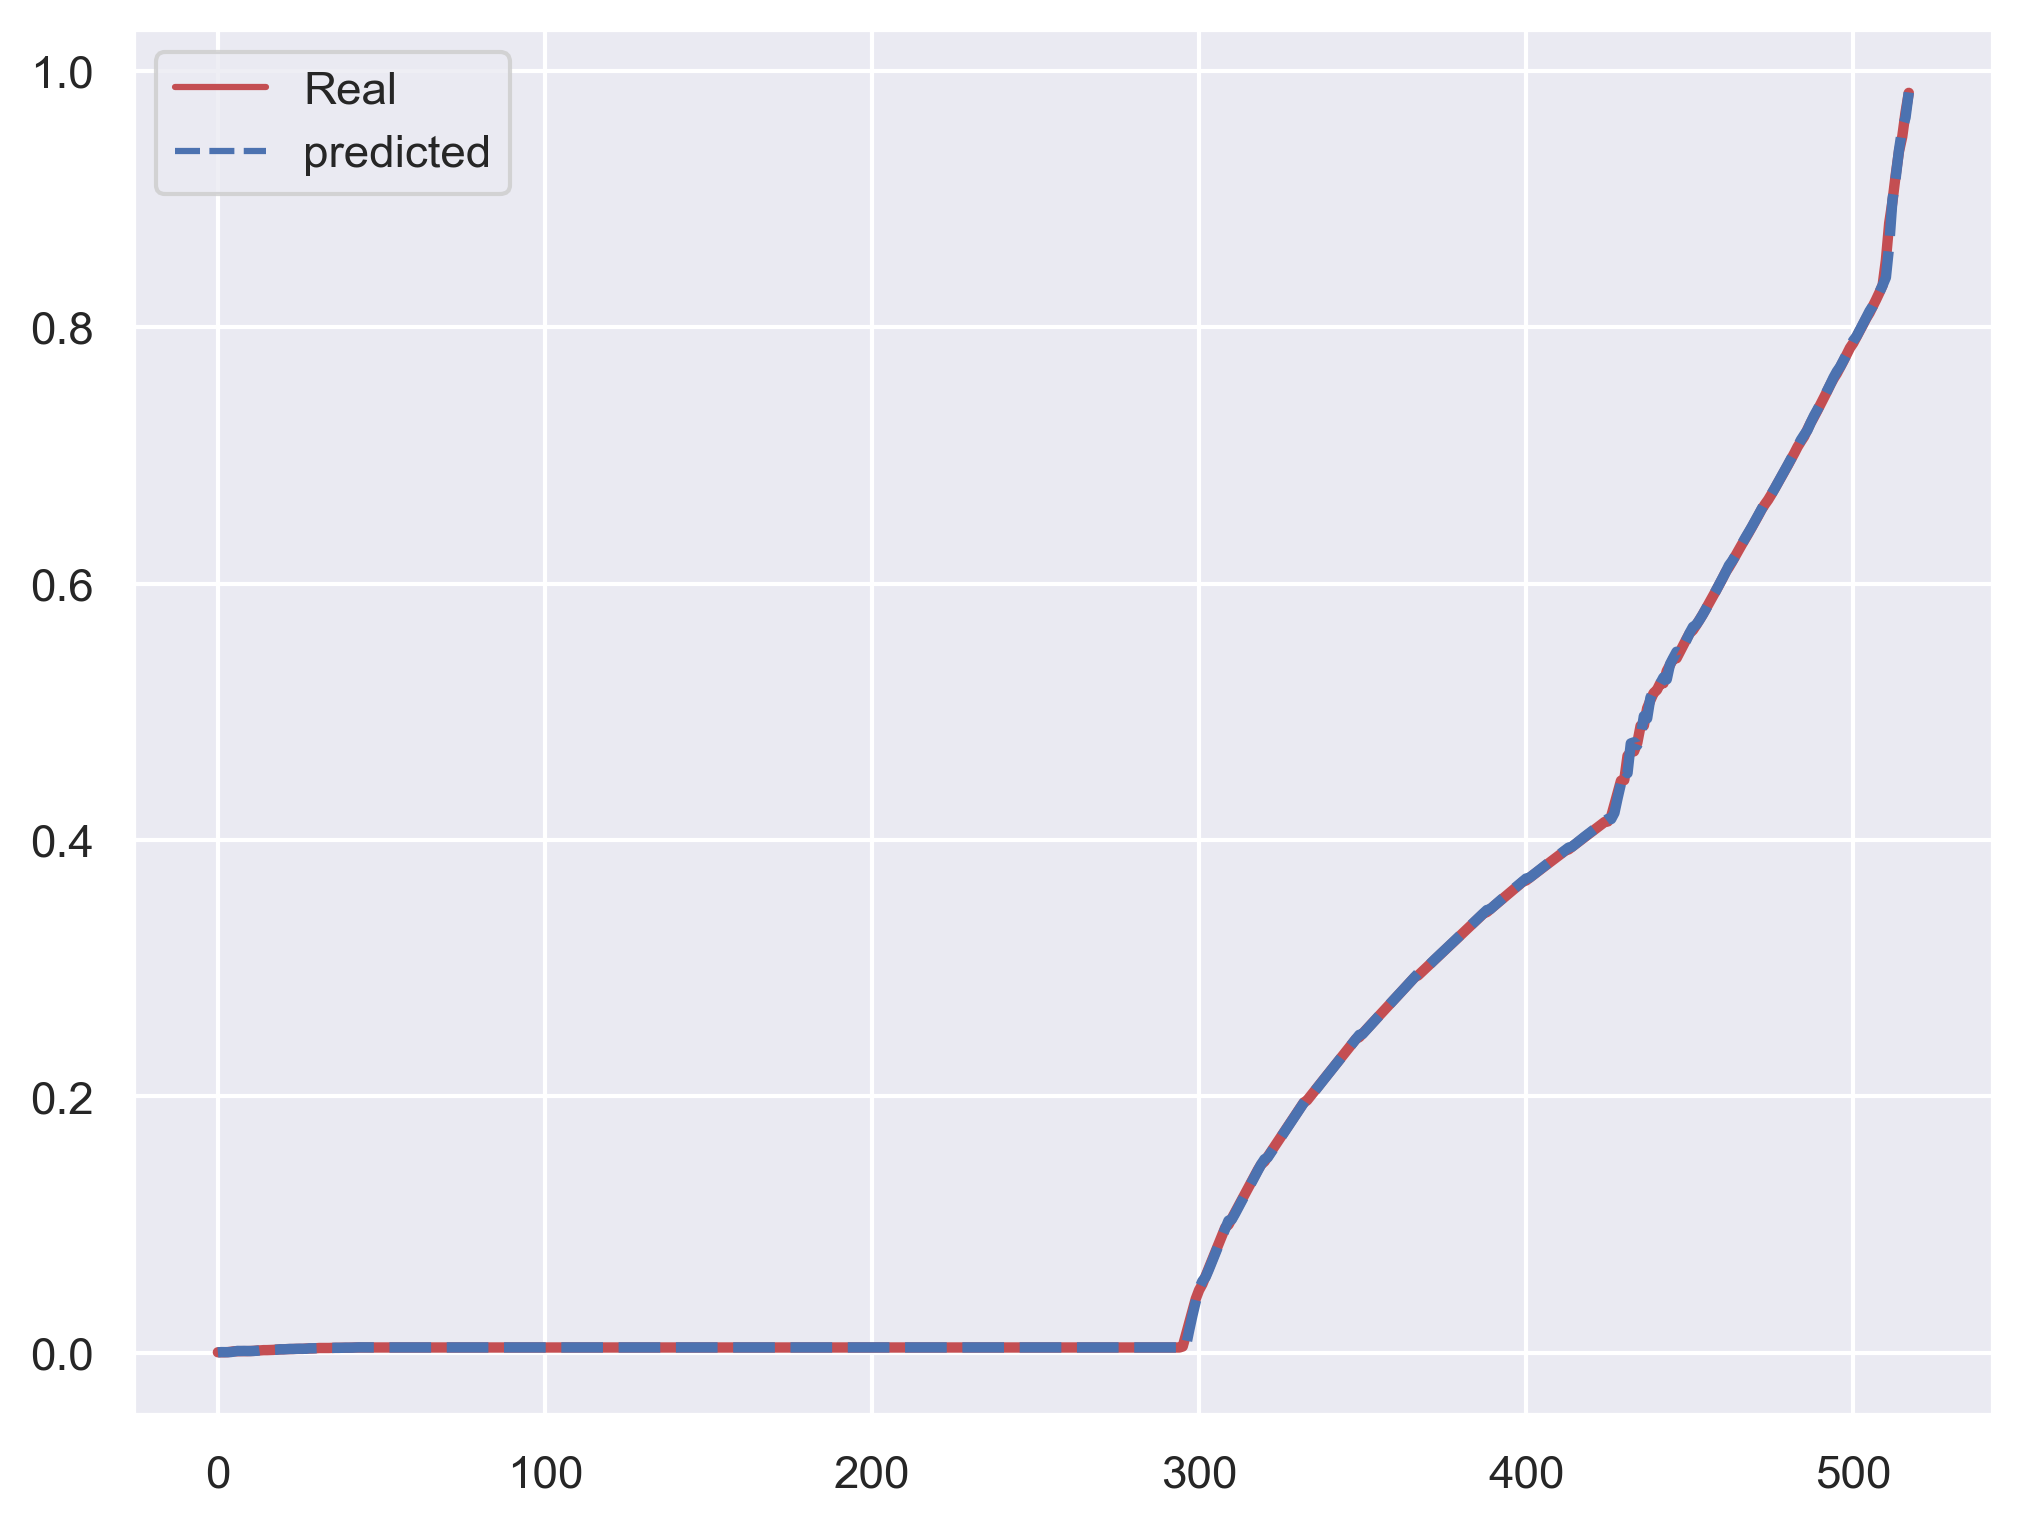

In [20]:
def store_result(model,name,y_train,y_test,train_pred,test_pred):
    print('Test set evaluation:\n_____________________________________')
    print_evaluate(y_test, test_pred)
    print('Train set evaluation:\n_____________________________________')
    print_evaluate(y_train, train_pred)
    mae,mse,rmse,r2s = evaluate(y_test, test_pred) 
    global results_df
    results_df = results_df.append({
        'Model' : name , 
        'MAE' : mae, 
        'MSE' : mse, 
        'RMSE' : rmse, 
        'R2 Square' : r2s 
    }, ignore_index =True)
    print(results_df)
results_df = pd.DataFrame()
def pltyy(Predict,Real):
    trainScore = math.sqrt(mean_squared_error(Real, Predict))
    print('Train Score: %.2f RMSE' % (trainScore))
    from matplotlib.pyplot import figure
    figure(figsize=(8, 6), dpi=300)
    plt.plot(Real)
    plt.plot(Predict)
    plt.legend(["True Value", "Prediction Value"], loc ="lower right")
    plt.show()
def ML_model(reg,X_train,y_train,name):
    reg.fit(X_train,y_train)
    pred = reg.predict(X_train)
    figure(figsize=(8, 6), dpi=300)
    df_eval =pd.DataFrame()
    df_eval['Real']=y_train
    df_eval['predicted']=pred
    sns.axes_style("darkgrid")
    figure(figsize=(8, 6), dpi=300)
    sns.lineplot(data = df_eval,palette=['r', 'b'], linewidth=2.5)
    results_df = pd.DataFrame()
    train_pred = pred
    print(df_eval)
    print('Train set evaluation:\n_____________________________________')
    print_evaluate(y_train, train_pred)
    print('_____________________________________')
    print('Name',name)
    store_result(reg,name,y_train,y_train,train_pred,train_pred)
from sklearn.linear_model import LinearRegression
from matplotlib.pyplot import figure

lin_reg = LinearRegression()
lin_reg.fit(X_train,y_train)
ML_model(lin_reg,X_train,y_train,'LinearRegression')

         Real  predicted
0    0.000490   0.000490
1    0.000490   0.000490
2    0.000490   0.000490
3    0.000588   0.000588
4    0.000883   0.000883
..        ...        ...
513  0.918857   0.918857
514  0.937046   0.937046
515  0.948568   0.948568
516  0.967543   0.967543
517  0.982742   0.982742

[518 rows x 2 columns]
Train set evaluation:
_____________________________________
MAE: 3.0166682262525763e-06
MSE: 1.1832391552232048e-09
RMSE: 3.439824349037614e-05
R2 Square 0.9999999822646192
__________________________________
_____________________________________
Name DecisionTreeRegressor
Test set evaluation:
_____________________________________
MAE: 3.0166682262525763e-06
MSE: 1.1832391552232048e-09
RMSE: 3.439824349037614e-05
R2 Square 0.9999999822646192
__________________________________
Train set evaluation:
_____________________________________
MAE: 3.0166682262525763e-06
MSE: 1.1832391552232048e-09
RMSE: 3.439824349037614e-05
R2 Square 0.9999999822646192
_______________________

<Figure size 2400x1800 with 0 Axes>

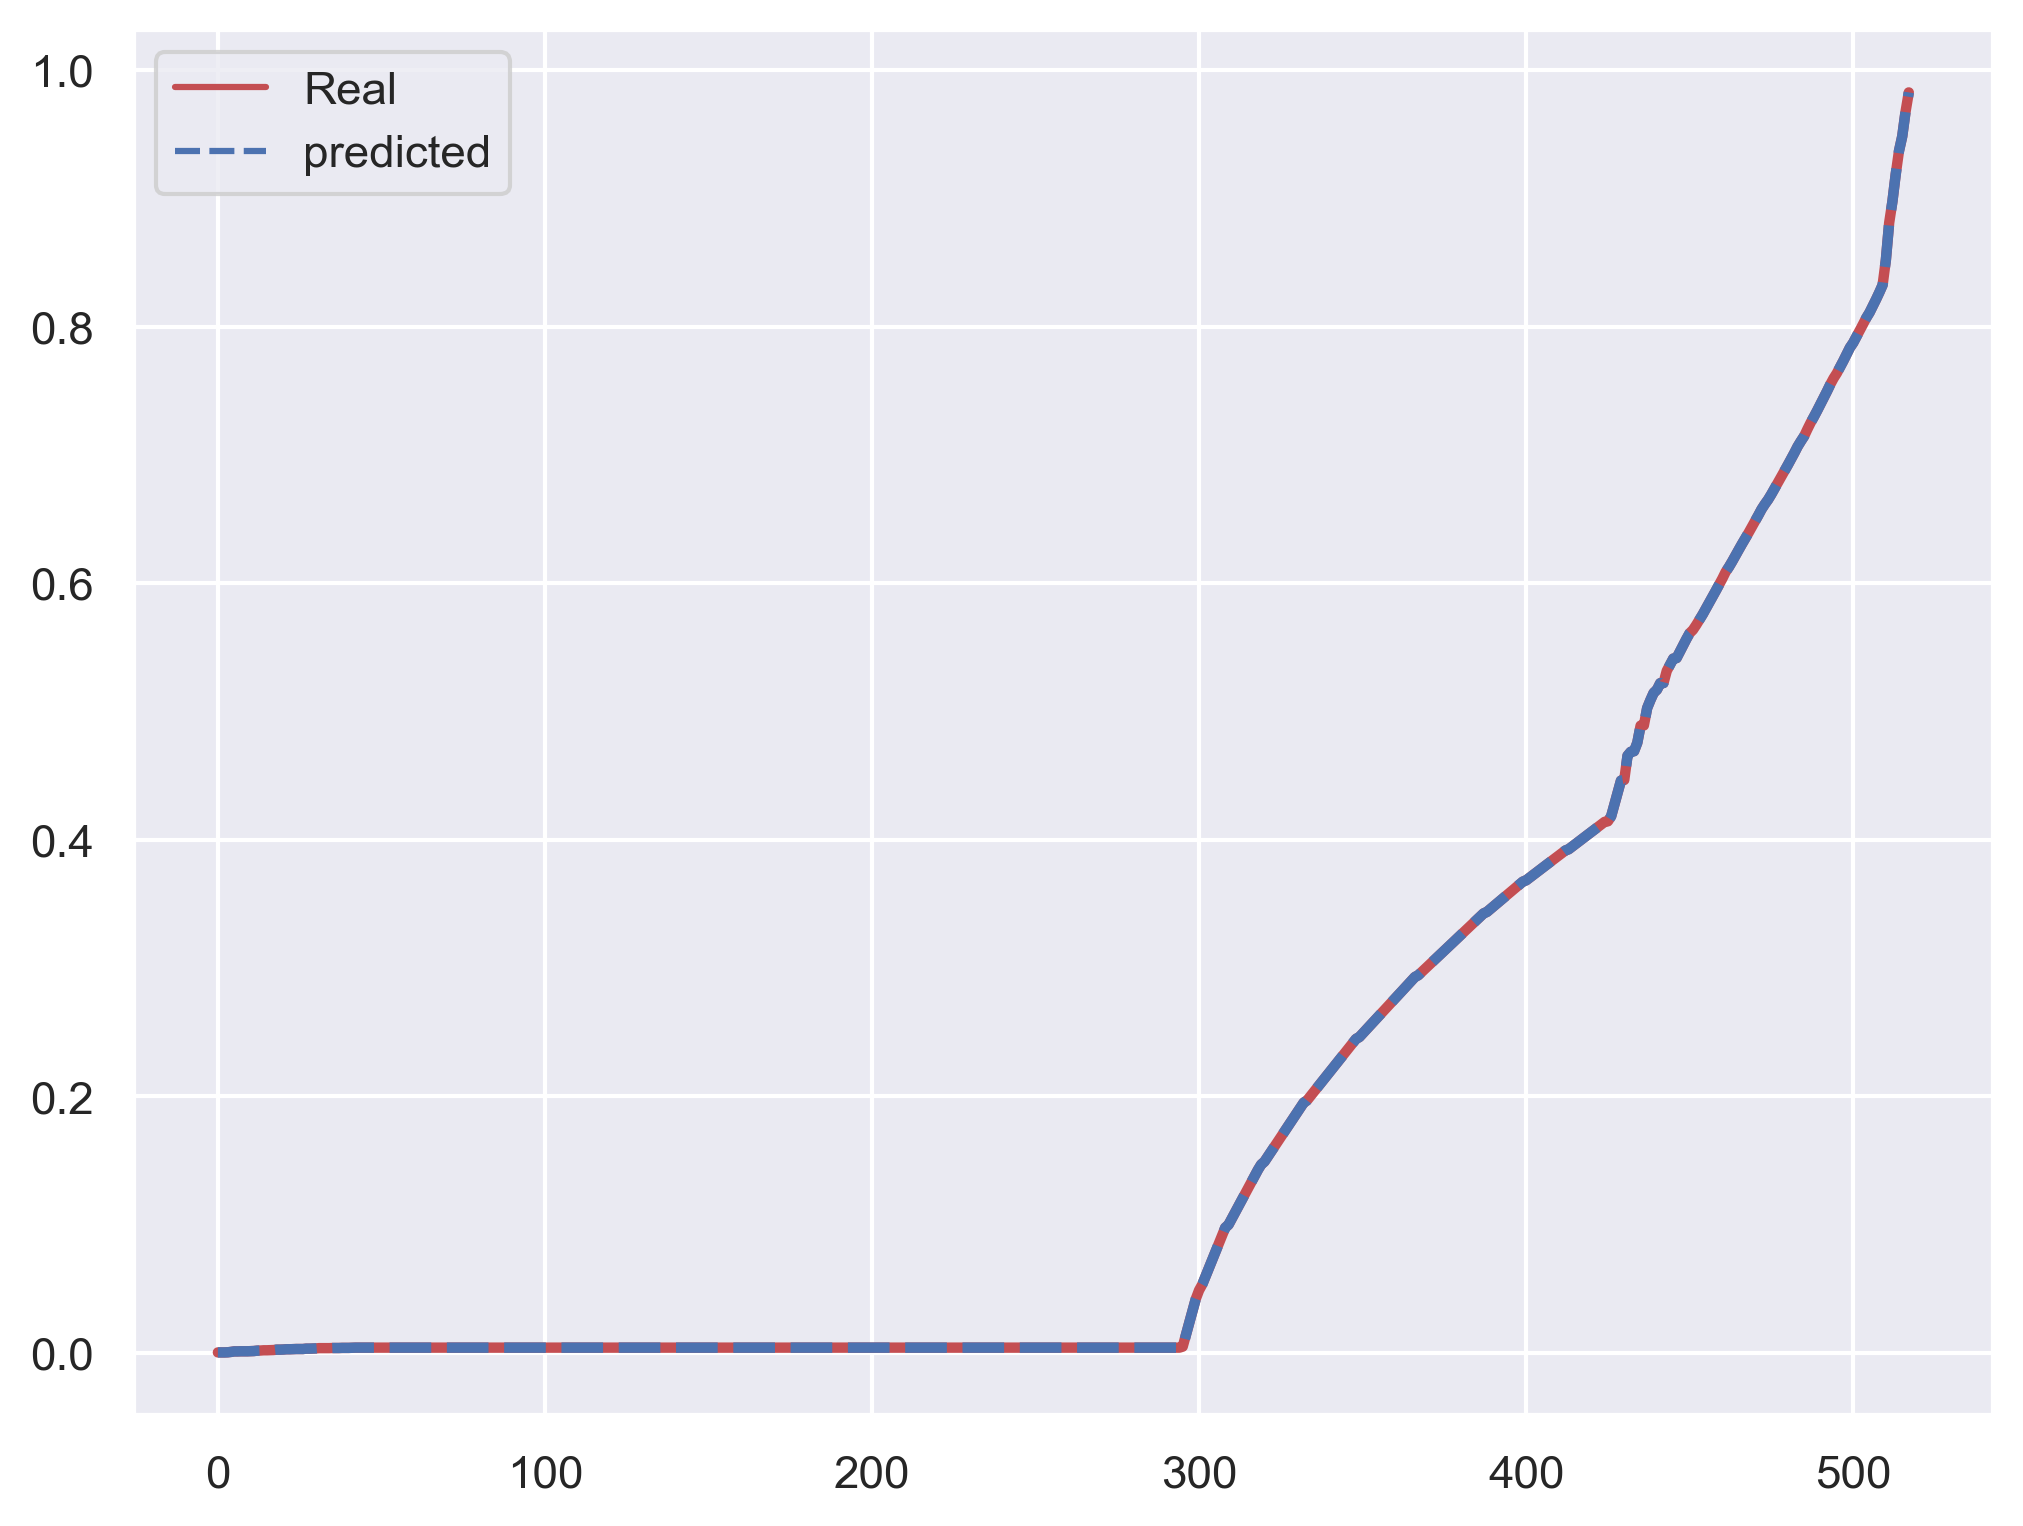

In [21]:
from sklearn.tree import DecisionTreeRegressor
reg = DecisionTreeRegressor(random_state=0)
ML_model(reg,X_train,y_train,'DecisionTreeRegressor')

         Real  predicted
0    0.000490   0.005510
1    0.000490   0.005510
2    0.000490   0.005510
3    0.000588   0.005510
4    0.000883   0.005510
..        ...        ...
513  0.918857   0.938189
514  0.937046   0.938189
515  0.948568   0.938189
516  0.967543   0.938189
517  0.982742   0.938189

[518 rows x 2 columns]
Train set evaluation:
_____________________________________
MAE: 0.007986121667823937
MSE: 0.00018201065620657264
RMSE: 0.01349113250274315
R2 Square 0.997271871639099
__________________________________
_____________________________________
Name AdaBoostRegressor
Test set evaluation:
_____________________________________
MAE: 0.007986121667823937
MSE: 0.00018201065620657264
RMSE: 0.01349113250274315
R2 Square 0.997271871639099
__________________________________
Train set evaluation:
_____________________________________
MAE: 0.007986121667823937
MSE: 0.00018201065620657264
RMSE: 0.01349113250274315
R2 Square 0.997271871639099
__________________________________
       

<Figure size 2400x1800 with 0 Axes>

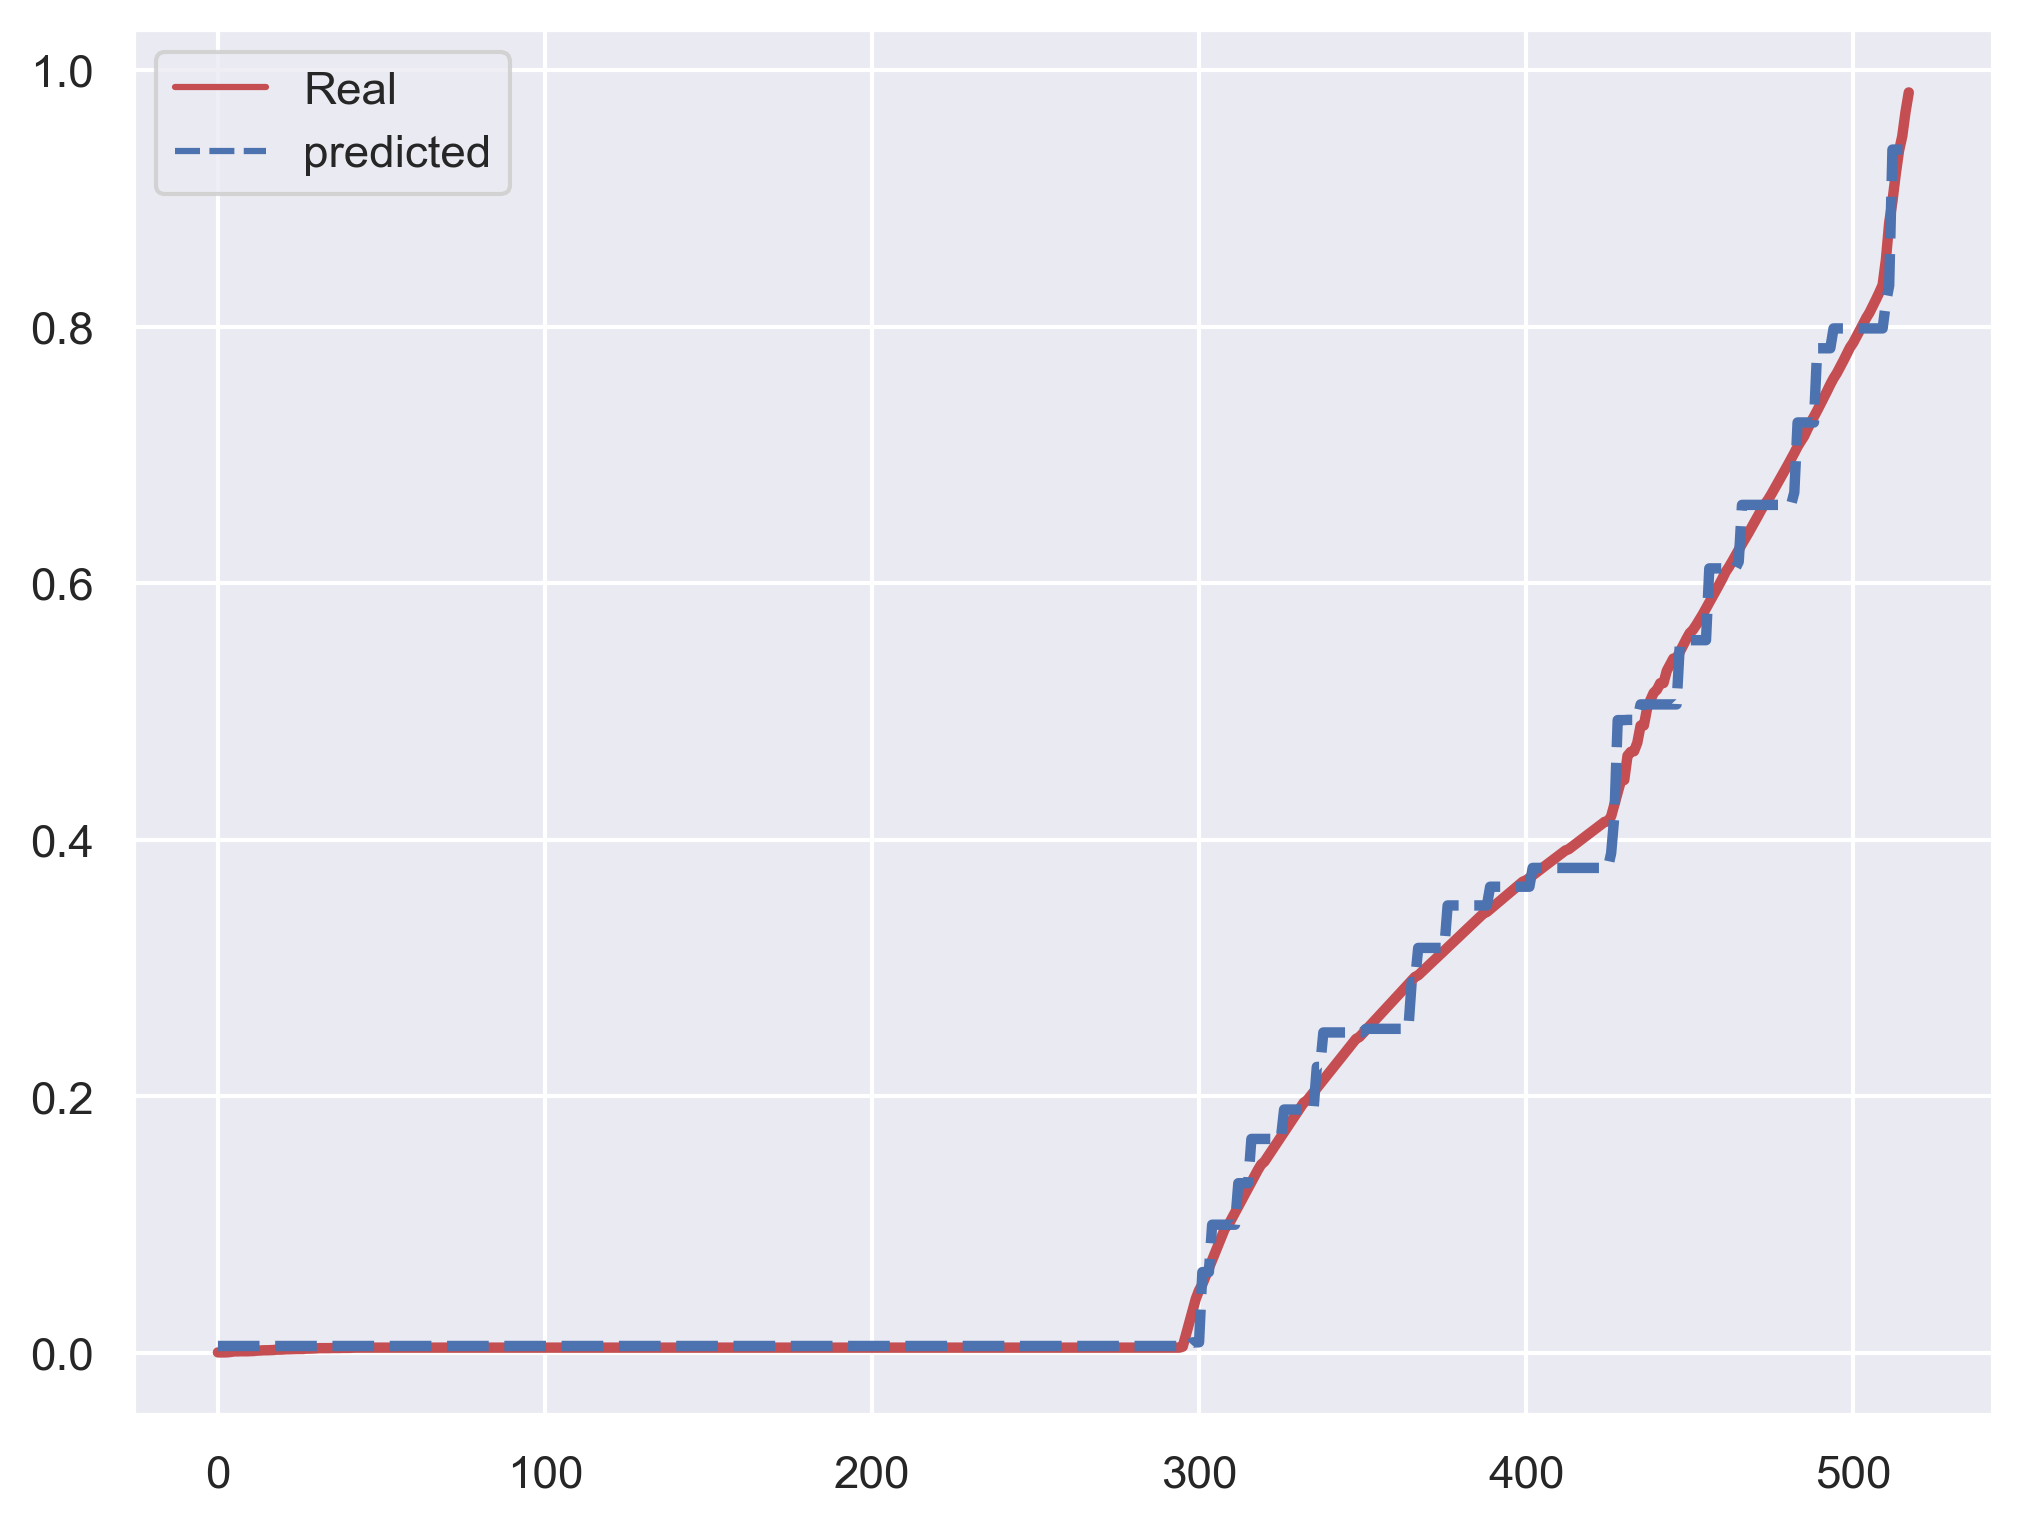

In [22]:
from sklearn.ensemble import AdaBoostRegressor
regr = AdaBoostRegressor(random_state=0, n_estimators=100)
ML_model(regr,X_train,y_train,'AdaBoostRegressor')

In [23]:
results_df

Model       MAE           MSE      RMSE  R2 Square
0       LinearRegression  0.000530  2.885575e-06  0.001699   0.999957
1  DecisionTreeRegressor  0.000003  1.183239e-09  0.000034   1.000000
2      AdaBoostRegressor  0.007986  1.820107e-04  0.013491   0.997272

## Hyperparamter Tunning

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, VotingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor
# Random Forest Regressor
rf_params = {
    'n_estimators': [10, 50, 100],  # Number of trees in the forest
    'max_depth': [None, 5, 10],     # Maximum depth of the trees
    'min_samples_split': [2, 5],    # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2],     # Minimum number of samples required to be at a leaf node
    'random_state': [0]
}
# Random Forest Regressor
rf = RandomForestRegressor(random_state=0)
rf_grid_search = GridSearchCV(estimator=rf, param_grid=rf_params, scoring='neg_mean_squared_error', cv=5)
rf_grid_search.fit(X_train,y_train) 

# Best hyperparameters and best score for the Random Forest Regressor
best_rf_params = rf_grid_search.best_params_
best_rf_score = rf_grid_search.best_score_
print("Best Random Forest Hyperparameters:", best_rf_params)
print("Best Random Forest Score (MSE):", -best_rf_score)


Best Random Forest Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10, 'random_state': 0}
Best Random Forest Score (MSE): 0.017425737226119824


# Crossvalidation

In [25]:
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score

# Assuming you have X and y containing the data and target labels

# Dictionary to store the F1-scores for each model
f1_scores = {}
models = [AdaBoostRegressor(random_state=0, n_estimators=100),
          RandomForestRegressor(max_depth= None, min_samples_leaf= 1, min_samples_split= 2, n_estimators= 100, random_state= 0),
         LinearRegression()]
# Perform cross-validation for each model
for model in models:
    # Calculate F1-score using cross_val_score
    f1_scores[model.__class__.__name__] = cross_val_score(model, X_train, y_train, cv=10, scoring='neg_root_mean_squared_error')

# Print the F1-scores for each model
for model_name, scores in f1_scores.items():
    print(f"{model_name} F1-scores: {scores}")
    print(f"Mean F1-score for {model_name}: {np.mean(scores)}")
    print("---")


AdaBoostRegressor F1-scores: [-0.01084231 -0.00848532 -0.00848532 -0.00848532 -0.00848532 -0.02664841
 -0.08676442 -0.06566199 -0.09676648 -0.17699428]
Mean F1-score for AdaBoostRegressor: -0.049761918743789615
---
RandomForestRegressor F1-scores: [-1.79298939e-03 -3.98056948e-06 -3.98056948e-06 -3.98056948e-06
 -3.98056948e-06 -1.70862324e-02 -5.14693191e-02 -3.30058015e-02
 -6.31981513e-02 -1.60513984e-01]
Mean F1-score for RandomForestRegressor: -0.03270823999191887
---
LinearRegression F1-scores: [-1.15610122e-04 -6.09415181e-05 -6.09415181e-05 -6.09415181e-05
 -6.09415181e-05 -1.81718609e-03 -5.57774811e-04 -5.32216439e-04
 -5.31431630e-03 -3.90421748e-03]
Mean F1-score for LinearRegression: -0.0012485087305127904
---


# Visualisation and Dashboard

In [26]:
def pltyy(Predict,Real):
    trainScore = math.sqrt(mean_squared_error(Real, Predict))
    print('Train Score: %.2f RMSE' % (trainScore))
    from matplotlib.pyplot import figure
    figure(figsize=(8, 6), dpi=300)
    plt.plot(Real)
    plt.plot(Predict)
    plt.legend(["True Value", "Prediction Value"], loc ="lower right")
    plt.show()
def ML_model(reg,X_train,y_train,name):
    reg.fit(X_train,y_train)
    pred = reg.predict(X_train)
    figure(figsize=(8, 6), dpi=300)
    df_eval =pd.DataFrame()
    df_eval['Real']=y_train
    df_eval['predicted']=pred
    sns.axes_style("darkgrid")
    figure(figsize=(8, 6), dpi=300)
    sns.lineplot(data = df_eval,palette=['r', 'b'], linewidth=2.5)
    plt.show()
    results_df = pd.DataFrame()
    train_pred = pred
    print('Evaluation:\n_____________________________________')
    print_evaluate(y_train, train_pred)

In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output
# Function to create bar plots
def plot(a, b, df, name):
    sns.set(rc={'figure.figsize': (11.7, 8.27)})
    ax = sns.barplot(x=a, y=b, data=df, errwidth=0)
    for i in ax.containers:
        ax.bar_label(i)
    plt.title(a)
    plt.savefig(a + '__' + name + '.jpg')
    plt.show()

# Function to create plots for all columns (except 'Algorithms' and 'split')
def plot_call(param,df, name):
    if param != 'Algorithms' and param != 'split':
            plot(param, 'Algorithms', df, name)

# Sample DataFrame for illustration purposes


# Create the interactive dashboard

# Create the interactive dashboard
def create_dashboard():
    column_selector = widgets.Dropdown(options=['RandomForest','Adaboost','LinearRegression'], description='Algorithm')
    output_plot = widgets.Output()
    def on_change(change):
        if change['type'] == 'change' and change['name'] == 'value':
            print(change)
            with output_plot:
                # Clear previous plot
                clear_output(wait=True)
                if column_selector.value == 'RandomForest':
                    ML_model(models[0],X_train,y_train,column_selector.value)
                elif column_selector.value == 'Adaboost':
                    ML_model(models[1],X_train,y_train,column_selector.value)
                else:
                    ML_model(models[2],X_train,y_train,column_selector.value)
    # Listen for changes in the dropdown selection
    column_selector.observe(on_change)

    # Display the dropdown selector and output plot
    display(column_selector)
    display(output_plot)

# Call the dashboard function with your DataFrame (e.g., Trainrdf)
create_dashboard()

Dropdown(description='Algorithm', options=('RandomForest', 'Adaboost', 'LinearRegression'), value='RandomFores…

Output()